This notebook continues where we left off in notebook 03. We will try to remove the white background from all of the segments and also add a parameter for the background color of the canvas.

In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torch.nn.functional as F
import torchvision.transforms as T

from PIL import Image
import json
from math import prod
from huggingface_hub import hf_hub_download
import tqdm
transform_t_to_pil = T.ToPILImage()
transform_to_t = transforms.Compose([transforms.ToTensor()])

First, we will just convert the initial image which will be segmented to RGBA. This should have no effect, but as im not sure, how torchvision reacts to it, we will try it out to be safe.

In [149]:
# Utility functions to read dataset

def get_all_bounding_boxes(item):
    all_boxes = []
    if "bounds" in item.keys():
        all_boxes.append(item["bounds"])
    if "children" in item.keys():
        for child in item["children"]:
            for box in get_all_bounding_boxes(child):
                all_boxes.append(box)
    return all_boxes
"""
returns a list of the segments and a list of coordinates
"""
def segment(image: np.ndarray, rico_json: dict)->[list,list]:
    boxes = get_all_bounding_boxes(rico_json["activity"]["root"])
    segments = []
    coordinates = []
    for box in boxes:
        anchor_point = (box[0],box[1])
        width = box[2]-box[0]
        height = box[3]-box[1]
        cropped_image = im.crop((box[0],box[1],box[2],box[3]))
        # Only include segments that are less than 90% the size of the original image
        if (width*height) < 0.9*(im.size[0]*im.size[1]):
            segments.append(cropped_image)
            coordinates.append((box[0],box[1]))
    return list(zip(segments,coordinates))

torch.Size([4, 168, 168])
torch.Size([4, 93, 491])
torch.Size([4, 142, 848])
torch.Size([4, 242, 888])
torch.Size([4, 76, 538])
torch.Size([4, 76, 444])
torch.Size([4, 168, 327])
torch.Size([4, 168, 1440])
torch.Size([4, 84, 1440])


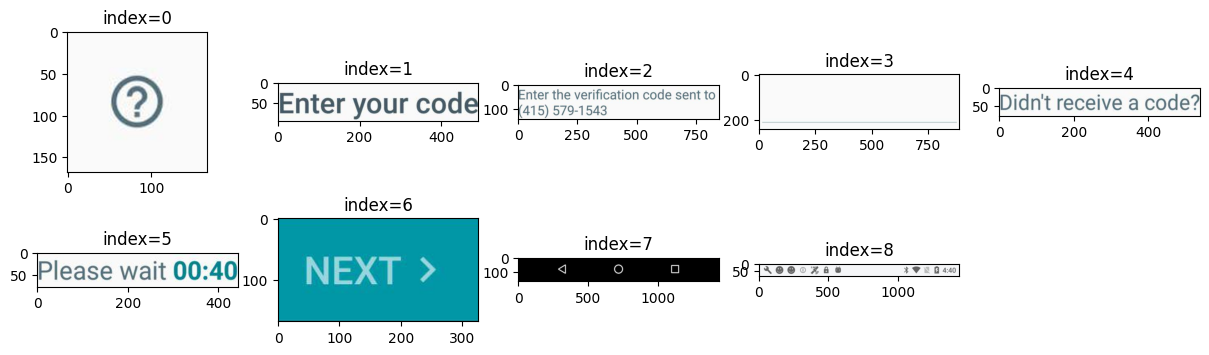

In [98]:
im = Image.open('combined/5373.jpg')
im = im.convert('RGBA')
im = im.resize((1440, 2560), Image.Resampling.LANCZOS)


with open("combined/5373.json", "r") as f:
    image_json = json.load(f)
    
reduced_segments = [s for s in segment(im,image_json) if (prod(s[0].size) < 0.80*prod(im.size)) and (prod(s[0].size)>1)]
even_more_reduced_segments = [reduced_segments[i] for i in [2,4,5,6,7,8,10,11,12]]
fig = plt.figure(figsize=(15, 4)) 
for n in range(len(even_more_reduced_segments)):
    fig.add_subplot(2, 5, n+1) 
    plt.imshow(even_more_reduced_segments[n][0])
    plt.title(f"index={n}")
    print(transform_to_t(even_more_reduced_segments[n][0]).shape)

At least the segmentation seems to work, we can see that we now have four channels instead of the usual three.

In [9]:
class AestheticPredictor(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=0)
        self.conv2 = torch.nn.Conv2d(32, 32, kernel_size=5, stride=1, padding=0)
        self.global_avg_pooling = torch.nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = torch.nn.Linear(32, 4096)
        self.dropout = torch.nn.Dropout(0.5)
        self.fc2 = torch.nn.Linear(4096, 1)
        # Download the model from HF Hub
        local_filename = hf_hub_download(repo_id="mowoe/modeling_how_different_user_groups_model", filename="model.pt")
        self.load_state_dict(torch.load(local_filename, map_location="cpu"))
        self.eval()

    def forward(self, x):
        x = torch.nn.functional.relu(self.conv1(x))
        x = torch.nn.functional.relu(self.conv2(x))
        x = self.global_avg_pooling(x)
        x = x.view(x.size(0), -1)
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [10]:
def calculate_initial_theta(segment, canvas_size, original_position):
    # Theta consists of 6 values, 4 of which we have to calculate.
    x_ratio = canvas_size[0] / segment.size[0]
    y_ratio = canvas_size[1] / segment.size[1]
    # grid_location_x and grid_location_y are basically percentages of height and width and not actual coordinates
    # Because we already warp the segment onto a bigger canvas, this transformation is a bit complicated
    # grid_location_x has to be in the interval [-(x_ratio-1),(x_ratio-1)], i.e. 0 means -(x_ratio - 1) and 1440 means (x_ratio - 1)
    # We can map U ~ [0, 1] to U ~ [a, b] with u -> (a - b)*u + b
    # We first map U ~ [0, max_width] to U ~ [0,1] by dividing by max_width
    original_x_position = original_position[0] / canvas_size[0]
    mapped_x_position = (-(x_ratio - 1) - (x_ratio - 1))*original_x_position + (x_ratio-1)

    original_y_position = original_position[1] / canvas_size[1]
    mapped_y_position = (-(y_ratio - 1) - (y_ratio - 1))*original_y_position + (y_ratio-1)

    return np.array([
        [x_ratio, 0.0    , mapped_x_position],
        [0.0    , y_ratio, mapped_y_position]
    ])

In [11]:
class MultiSegmentUIOptimizer(torch.nn.Module):
    def __init__(self,segments_and_positions: list, original_image_size: tuple, debug=False,debug_stacking_strategy="sum"):
        super().__init__()
        self.original_image_size = original_image_size
        self.segments_and_positions = segments_and_positions
        self.canvas_size = (1,3,original_image_size[1],original_image_size[0])
        self.debug_stacking_strategy = debug_stacking_strategy
        self.debug = debug
        print(f"Canvas size is {self.canvas_size}")

        initial_vector = []
        for segment,position in segments_and_positions:
            initial_theta = calculate_initial_theta(segment,original_image_size,position)
            initial_vector.append([initial_theta[0][2],initial_theta[1][2]])

        self.coordinates = torch.nn.Parameter(torch.tensor(initial_vector))
        print(self.coordinates)
        #init_vector = -5 * torch.rand(len(segments),2) + 2.5 # https://stackoverflow.com/questions/65617507/how-to-create-a-tensor-of-given-shape-and-interval 
        #self.coordinates = torch.nn.Parameter(init_vector) # 2 floats per segment, for grid_location_x and grid_location_y
        

    def forward(self):
        segments_on_canvas = []
        for n in range(len(self.segments_and_positions)):
            # We need to calculate the proper ratios, to artificially warp the segment on to a bigger canvas without distorting it (see notebook 01)
            x_ratio = self.original_image_size[0] / self.segments_and_positions[n][0].size[0]
            y_ratio = self.original_image_size[1] / self.segments_and_positions[n][0].size[1]
            # Affine matrix
            ########### WILL BREAK GRADIENT! ###########
            #theta = [
            #    [x_ratio, 0.0    , self.coordinates[n][0]],
            #    [0.0    , y_ratio, self.coordinates[n][1]]
            #]

            theta = [
                [x_ratio, 0.0    , 0.0],
                [0.0    , y_ratio, 0.0]
            ]
            theta_tensor = torch.as_tensor(theta)[None]
            #print(theta_tensor)
            theta_tensor[0][0][2]+=self.coordinates[n][0]
            theta_tensor[0][1][2]+=self.coordinates[n][1]
            #print(theta_tensor)
            
            ############################################
            
            # Generate flow field
            grid = F.affine_grid(theta_tensor, self.canvas_size).type(torch.FloatTensor)
            x = F.grid_sample(transform_to_t(self.segments_and_positions[n][0]).unsqueeze(0), grid)
            segments_on_canvas.append(x)
            if self.debug:
                if self.debug_stacking_strategy=="mean":
                    canvas_sum = torch.stack(segments_on_canvas).mean(dim=0)[0].permute(1, 2, 0).detach()
                else:
                    canvas_sum = torch.stack(segments_on_canvas).sum(dim=0)[0].permute(1, 2, 0).detach()
                plt.imshow(canvas_sum)
                plt.axis('off')
                plt.show()
        return segments_on_canvas

In [12]:
device = "cpu"
reduced_msUIo = MultiSegmentUIOptimizer(even_more_reduced_segments, im.size)
optimizer = torch.optim.SGD([reduced_msUIo.coordinates], lr=0.01, momentum=0.9)
aesthetic_predictor = AestheticPredictor()#.to(device, torch.float16)

Canvas size is (1, 3, 2560, 1440)
Parameter containing:
tensor([[ -5.8048,  13.3037],
        [  1.6321,  21.3044],
        [  0.5895,  12.0661],
        [  0.5249,   5.3056],
        [  1.4158,  11.2097],
        [  1.8943,   9.2690],
        [ -1.8578, -10.5006],
        [  0.0000, -12.3693],
        [  0.0000,  29.4762]], dtype=torch.float64, requires_grad=True)


In [13]:
scores = []
for x in tqdm.tqdm(range(15)):
    optimizer.zero_grad()
    canvasses = reduced_msUIo()
    generated_image = torch.stack(canvasses).sum(dim=0)
    print(torch.sum(generated_image))
    score = aesthetic_predictor(generated_image)
    print(f"score: {score.item()}")
    loss = -score
    loss.backward()
    optimizer.step()
    #print(reduced_msUIo.coordinates)
    scores.append(score.item())

  0%|                                                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]/Users/mowoe/Documents/bachelorthesis/venv/lib/python3.11/site-packages/torch/nn/functional.py:4377: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/Users/mowoe/Documents/bachelorthesis/venv/lib/python3.11/site-packages/torch/nn/functional.py:4316: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
  0%|                                                                               

tensor(2663945., grad_fn=<SumBackward0>)


RuntimeError: Given groups=1, weight of size [32, 3, 5, 5], expected input[1, 4, 2560, 1440] to have 3 channels, but got 4 channels instead

We see that this wont work, because adding a fourth channel doesnt fit the input layer of our aesthetic classifier. This is, of course, not very surprising. This means we need to remove the alpha channel before passing it into the aesthetics classifier. But we cant just remove the dimension, but need to do actual [Alpha blending](https://en.wikipedia.org/wiki/Alpha_compositing). Fourtunately, this can be done with simple arithmetic operations in torch, so we dont need to worry about breaking differentiability.

To test this, we will first just use two segments and a purple background.

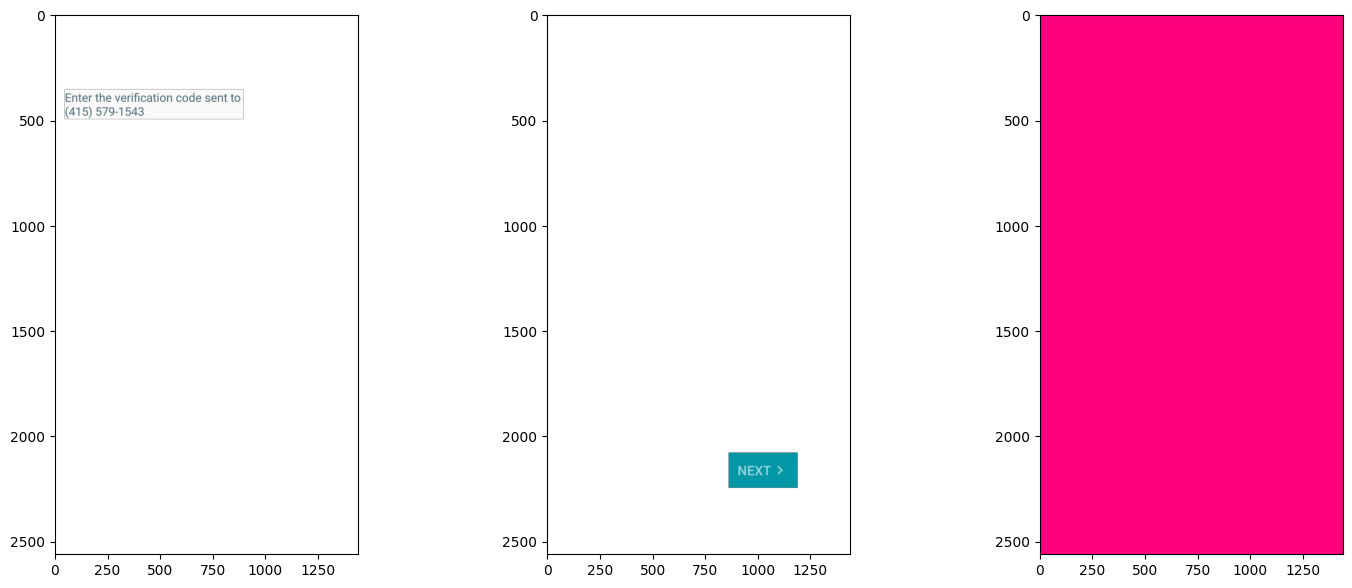

In [101]:
canvas_size = (1,3,im.size[1],im.size[0])

segment_1 = even_more_reduced_segments[2]
segment_2 = even_more_reduced_segments[6]

initial_theta_1 = torch.as_tensor(calculate_initial_theta(segment_1[0],im.size,segment_1[1]))[None]
initial_theta_2 = torch.as_tensor(calculate_initial_theta(segment_2[0],im.size,segment_2[1]))[None]

grid_1 = F.affine_grid(initial_theta_1, canvas_size).type(torch.FloatTensor)
transformed_segment_1 = F.grid_sample(transform_to_t(segment_1[0]).unsqueeze(0), grid_1)

grid_2 = F.affine_grid(initial_theta_2, canvas_size).type(torch.FloatTensor)
transformed_segment_2 = F.grid_sample(transform_to_t(segment_2[0]).unsqueeze(0), grid_2)

red = torch.tensor(np.array([1]*(im.size[0]*im.size[1])).reshape((im.size[1],im.size[0])))
green =  torch.zeros((im.size[1],im.size[0]))
blue = torch.tensor(np.array([0.5]*(im.size[0]*im.size[1])).reshape((im.size[1],im.size[0])))
alpha =  torch.ones((im.size[1],im.size[0])) # Alpha=1 means full opacity
background = torch.stack([red, green, blue, alpha]) # rgba(1.0,0.0,0.5,1)

fig = plt.figure(figsize=(18, 7)) 
fig.add_subplot(1, 3, 1) 
plt.imshow(transformed_segment_1[0].permute(1, 2, 0).detach())
fig.add_subplot(1, 3, 2) 
plt.imshow(transformed_segment_2[0].permute(1, 2, 0).detach())
fig.add_subplot(1, 3, 3) 
plt.imshow(background.permute(1, 2, 0).detach())
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


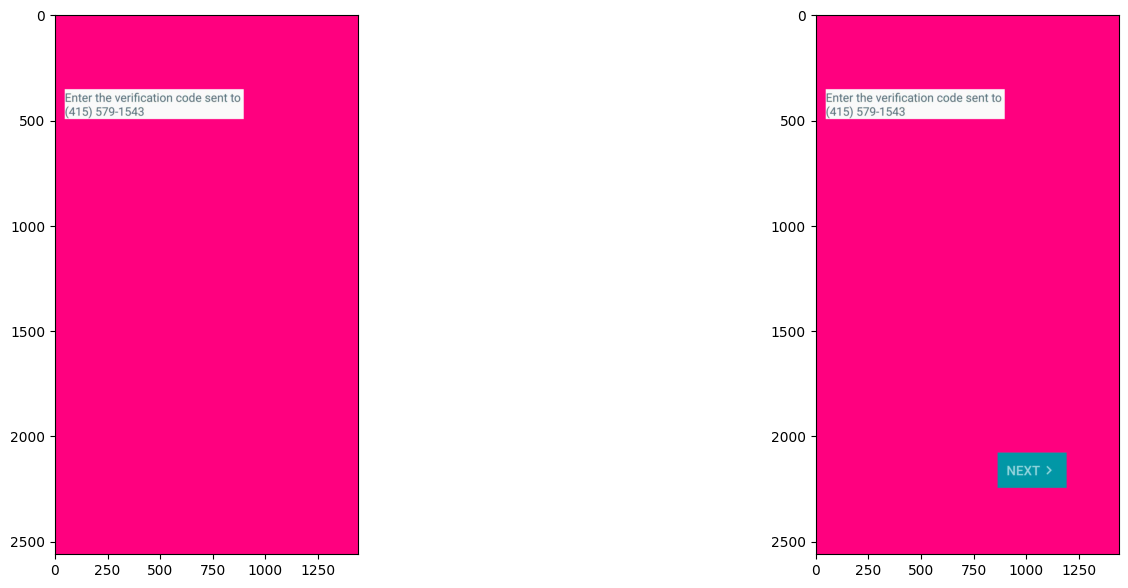

In [125]:
def stack_a_on_b(a,b):
    mask = ((1 - a[3]) * b)[:3]
    mask = torch.cat((mask,b[3].unsqueeze(0)))
    return torch.stack([a,mask]).sum(dim=0)

fig = plt.figure(figsize=(18, 7)) 

stacked_im = stack_a_on_b(transformed_segment_1[0],background)
fig.add_subplot(1, 2, 1) 
plt.imshow(stacked_im.permute(1, 2, 0))

stacked_im_2 = stack_a_on_b(transformed_segment_2[0],stacked_im)
fig.add_subplot(1, 2, 2) 
plt.imshow(stacked_im_2.permute(1, 2, 0))

plt.show()

After we reassembled the UI, we can just remove the alpha channel, because we dont need it anymore (and we cant pass it to the aesthetic predictor):

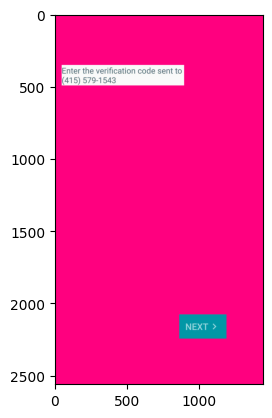

In [126]:
plt.imshow(stacked_im_2[:3].permute(1, 2, 0))
plt.show()

Before we can finally use this, lets try to modify the function so it accepts multiple images instead of just two:

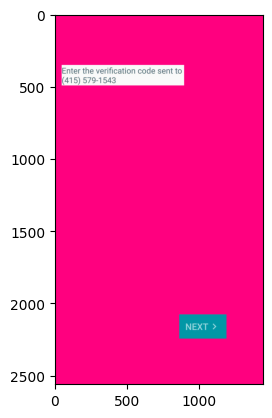

In [127]:
def stack_alpha_aware(images):
    if len(images[0].shape) == 4:
        running_top_image = torch.zeros_like(images[0][0])
    else:
        running_top_image = torch.zeros_like(images[0])
    for image in images:
        if len(image.shape) == 4:
            running_top_image = stack_a_on_b(running_top_image,image[0])
        else:
            running_top_image = stack_a_on_b(running_top_image,image)
    return running_top_image

stacked_img = stack_alpha_aware([transformed_segment_1[0],transformed_segment_2[0],background])
plt.imshow(stacked_img[:3].permute(1, 2, 0))
plt.show()

Now we can integrate this stacking into our training loop

In [128]:
device = "cpu"
reduced_msUIo = MultiSegmentUIOptimizer(even_more_reduced_segments, im.size)
optimizer = torch.optim.SGD([reduced_msUIo.coordinates], lr=0.01, momentum=0.9)
aesthetic_predictor = AestheticPredictor()#.to(device, torch.float16)

Canvas size is (1, 3, 2560, 1440)
Parameter containing:
tensor([[ -5.8048,  13.3037],
        [  1.6321,  21.3044],
        [  0.5895,  12.0661],
        [  0.5249,   5.3056],
        [  1.4158,  11.2097],
        [  1.8943,   9.2690],
        [ -1.8578, -10.5006],
        [  0.0000, -12.3693],
        [  0.0000,  29.4762]], dtype=torch.float64, requires_grad=True)


In [138]:
scores = []
images_for_gif = []

for x in tqdm.tqdm(range(15)):
    optimizer.zero_grad()
    canvasses = reduced_msUIo()

    # Here we now need to add our alpha channel capable stacking
    # Before:
    # generated_image = torch.stack(canvasses).sum(dim=0)
    # Now:
    generated_image = stack_alpha_aware(canvasses)
    # Remove Alpha channel
    generated_image = generated_image[:3]

    score = aesthetic_predictor(generated_image.unsqueeze(0))
    
    # plt.imshow(generated_image.detach().cpu().permute(1, 2, 0))
    # plt.show()
    # print(f"score: {score.item()}")
    
    loss = -score
    loss.backward()
    optimizer.step()

    scores.append(score.item())

    # Save image as png to create gif
    pil_image = transform_t_to_pil(generated_image.detach())
    pil_image.save(f"{x}.png")
    images_for_gif.append(f"{x}.png")

print(f"Final Score: {score[-1]}")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [05:06<00:00, 20.46s/it]

Final Score: tensor([5.4943], grad_fn=<SelectBackward0>)


In [145]:
# Create gif from steps
import imageio

images = []
for filename in images_for_gif:
    images.append(imageio.imread(filename))
imageio.mimsave('./progress.gif', images, loop=65535)

/var/folders/zp/wdq5n2513f916zsjngb1hs_c0000gn/T/ipykernel_8703/1743404678.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))


/var/folders/zp/wdq5n2513f916zsjngb1hs_c0000gn/T/ipykernel_8703/1640575541.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML



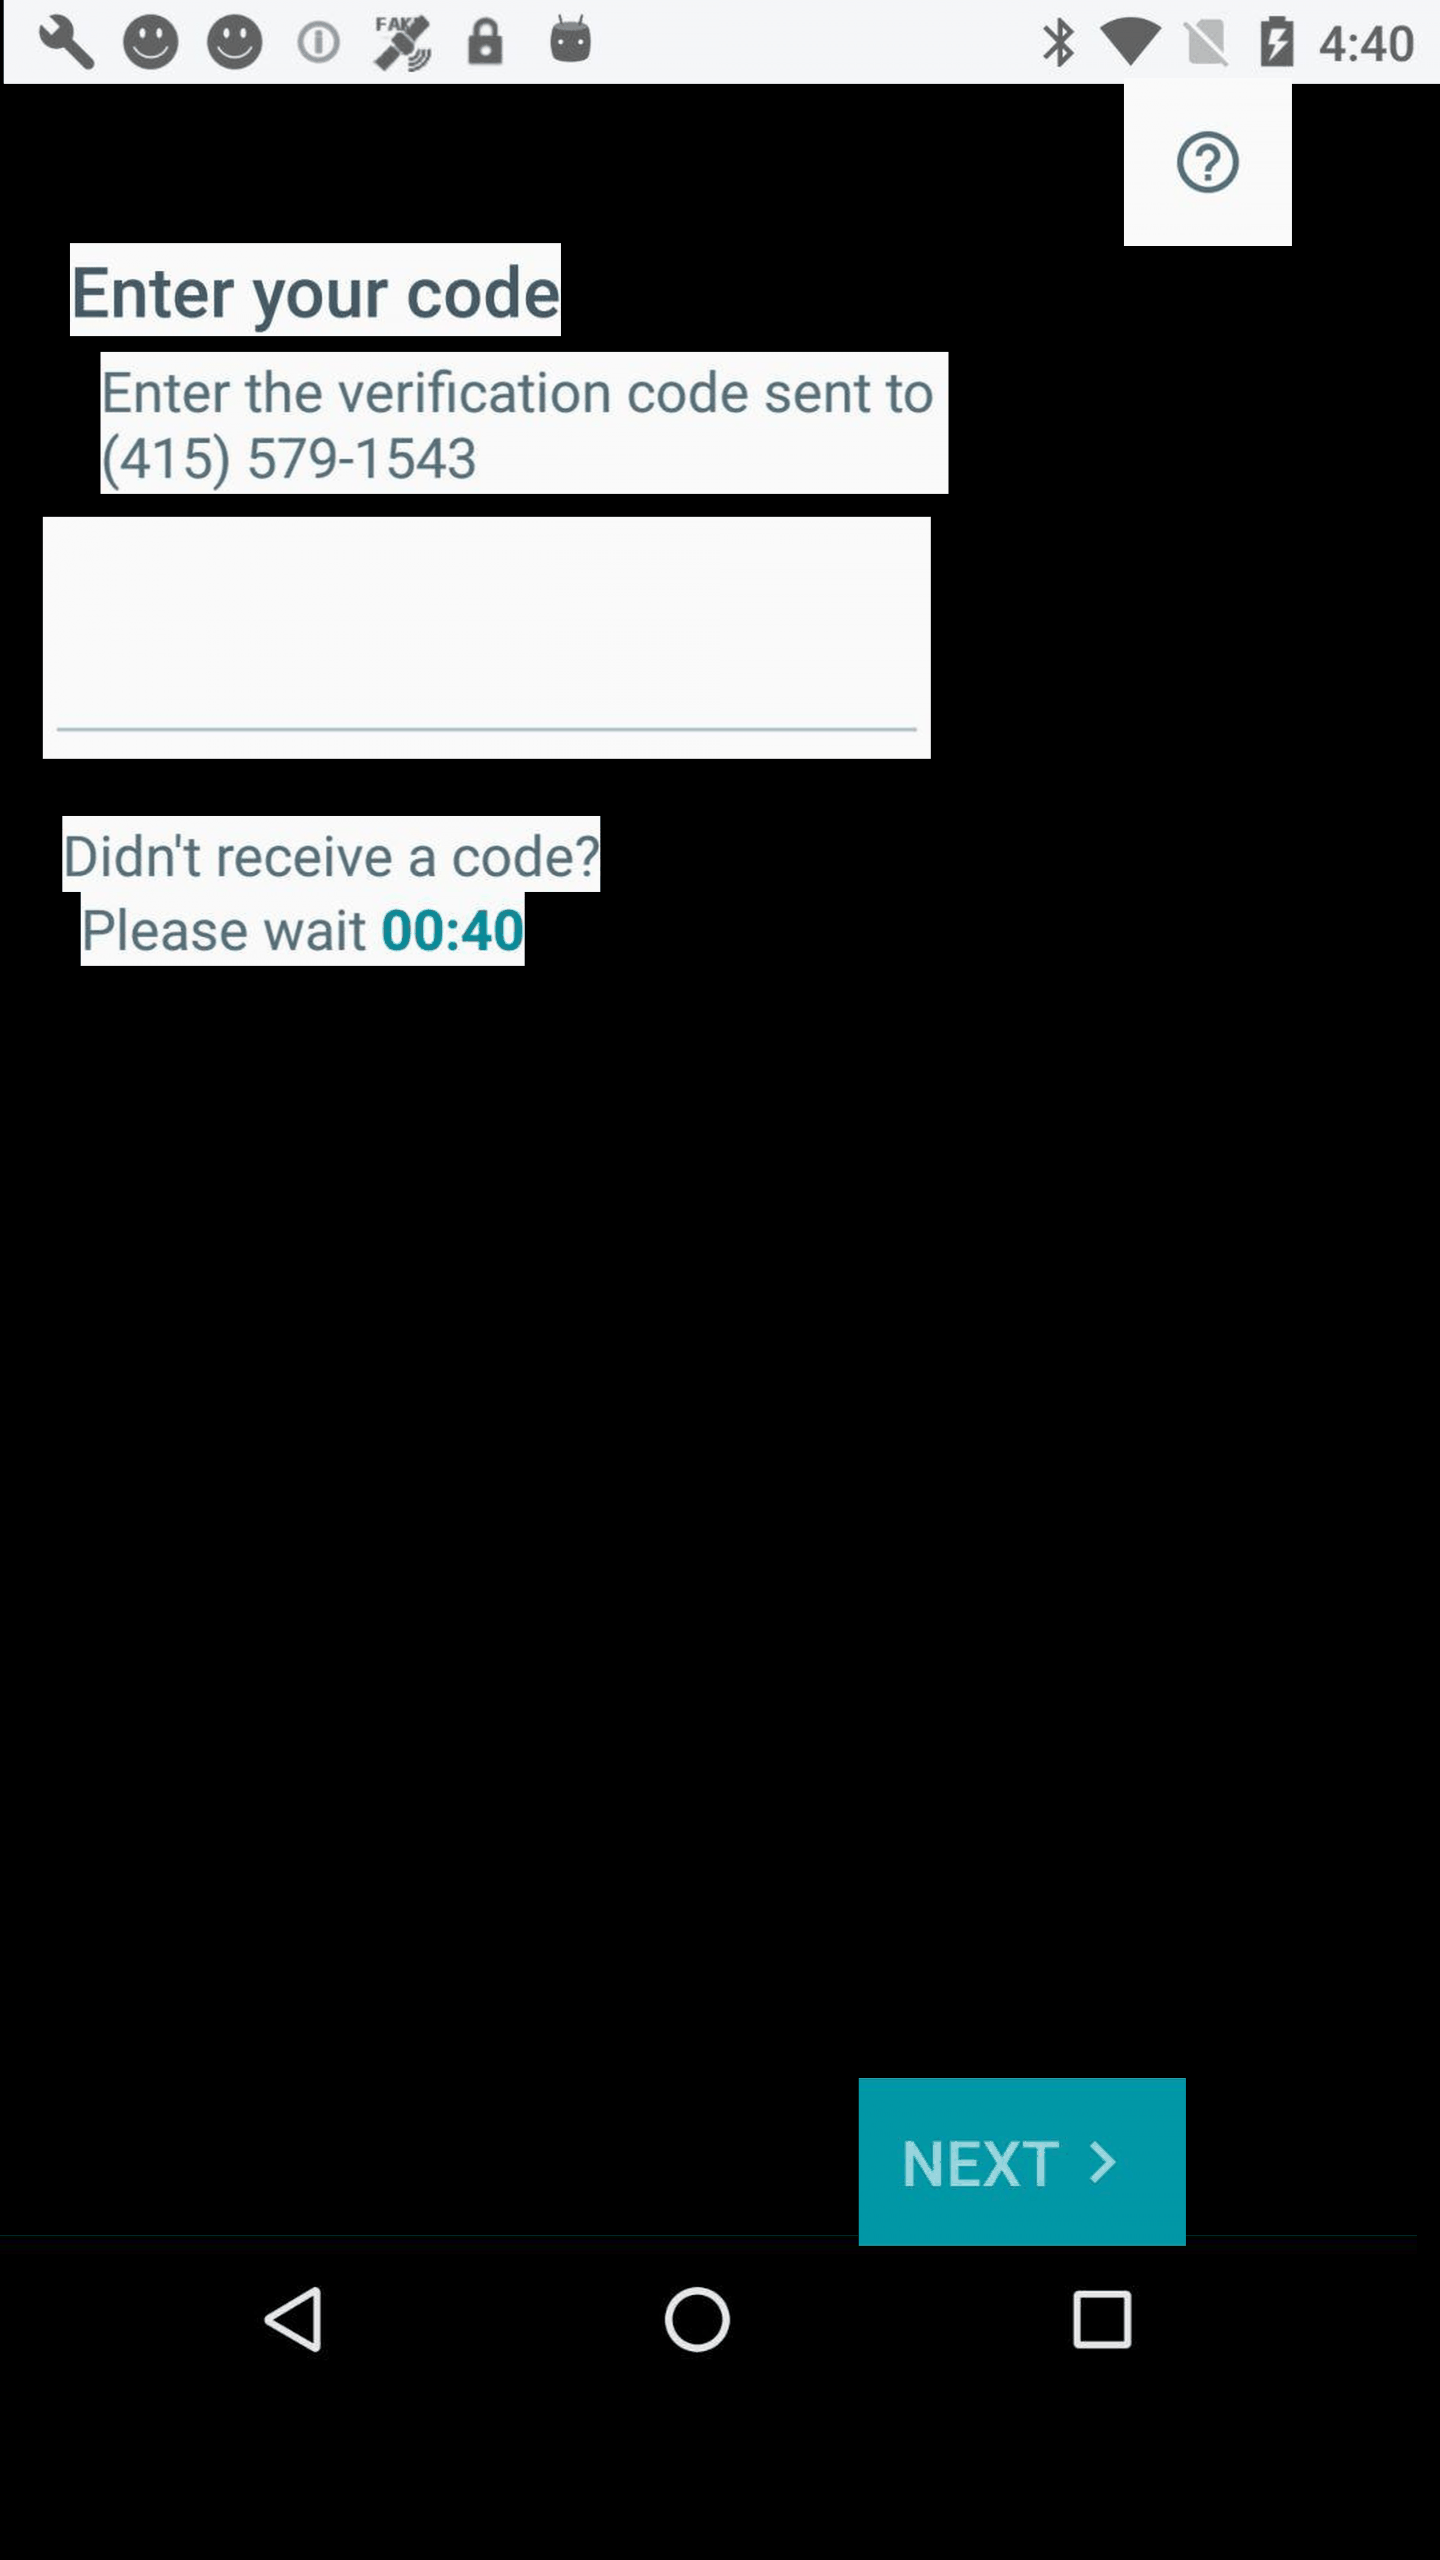

In [146]:
import base64
from IPython.core.display import display, HTML

b64 = base64.b64encode(open('./progress.gif','rb').read()).decode('ascii')
display(HTML(f'<img src="data:image/gif;base64,{b64}" />'))

<function matplotlib.pyplot.show(close=None, block=None)>

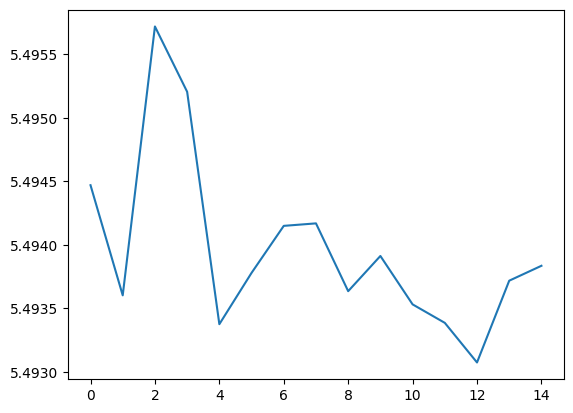

In [130]:
plt.plot(scores)
plt.show

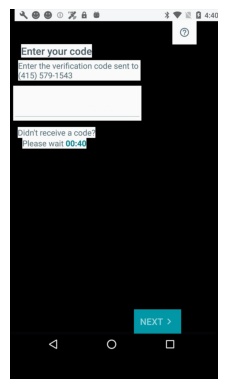

In [148]:
canvasses = reduced_msUIo()

generated_image = stack_alpha_aware(canvasses)
# Remove Alpha channel
generated_image = generated_image[:3]

plt.imshow(generated_image.detach().permute(1, 2, 0))
plt.axis('off')
plt.show()